In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'labels.csv', 'sample_submission.csv', 'train']


In [37]:
%matplotlib inline

In [38]:
from fastai.vision import *

In [39]:
path = Path('../input')

In [40]:
df = pd.read_csv(f'{path}/labels.csv', low_memory=False)
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [41]:
df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


In [42]:
sz=224
bs=64

In [43]:
files = get_image_files(path/'train'); files[:4]

[PosixPath('../input/train/53114939929c74ccb6c64c373ed7bedb.jpg'),
 PosixPath('../input/train/c8eab8d5c97dfaf0bd993d6ad59895a6.jpg'),
 PosixPath('../input/train/49b3f86003cd0a64d219862067cac95d.jpg'),
 PosixPath('../input/train/5a8902409f3b0563d60adeaf8482af1f.jpg')]

In [44]:
tfms = get_transforms(max_rotate=25, max_zoom=1.25)
len(tfms)

2

In [45]:
def get_ex(files, indx):
    return open_image(files[indx])

def plots_f(files, indx, idx, rows, cols, width, height, **kwargs):
    [get_ex(files, indx).apply_tfms(tfms[idx], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

0
1


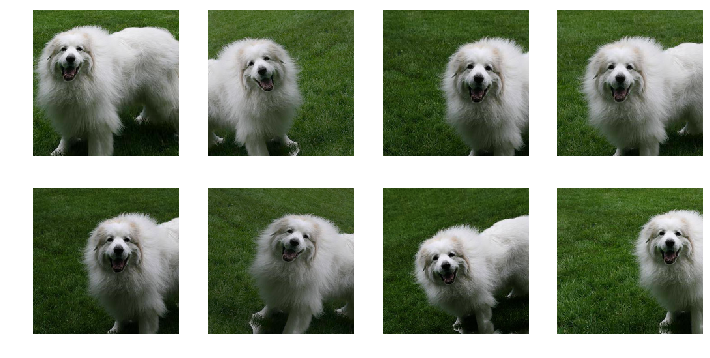

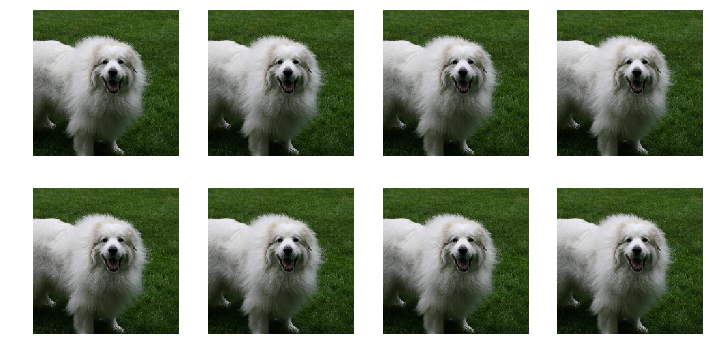

In [46]:
for t, tfm in enumerate(tfms):
    print(t)
    plots_f(files, 15, t, 2, 4, 12, 6, size=224)

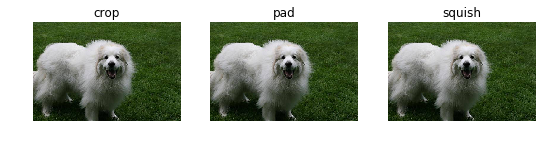

In [47]:
_, axs = plt.subplots(1, 3, figsize=(9, 5))
for rsz, ax in zip([ResizeMethod.CROP, ResizeMethod.PAD, ResizeMethod.SQUISH, ResizeMethod.mro], axs):
    (get_ex(files, 15).apply_tfms([crop_pad()], size=224, resize_method=224, padding_mode='zeros')
     .show(ax=ax, title=rsz.name.lower()))

In [48]:
# tfms = get_transforms(max_rotate=25, max_zoom=1.25)
# data = (ImageDataBunch.from_csv(path=path, csv_labels='labels.csv', folder='train', test='test',
#                                 valid_pct=0.2, size=sz, bs=bs, ds_tfms=tfms,
#                                 suffix='.jpg')).normalize(imagenet_stats)


In [49]:
# (ImageList.from_csv(path=path, csv_name='labels.csv', test='test')
#        .split_by_rand_pct(0.2, seed=2)
#        .label_from_df('breed')
#        .transform(tfms, size=sz)
#        .databunch(bs=bs)
#        .normalize(imagenet_stats))

In [50]:
def get_data(sz, bs):
    tfms = get_transforms(max_rotate=20, max_zoom=1.2)
    data = (ImageList.from_df(df, path=path, folder='train', suffix='.jpg')
           .split_by_rand_pct(0.2, seed=2)
           .label_from_df('breed')
           .transform(tfms, size=sz)
           .databunch(bs=bs)
           .normalize(imagenet_stats))
    return data

In [51]:
data = get_data(224, 64)

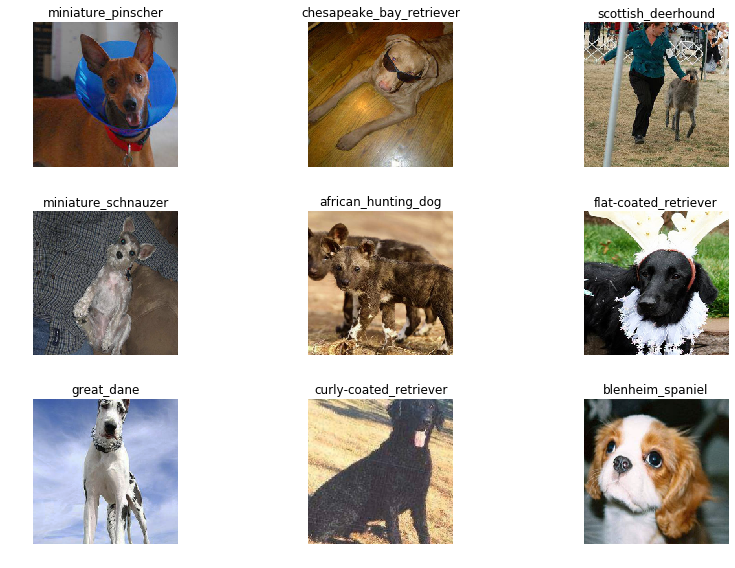

In [52]:
data.show_batch(rows=3, figsize=(12, 8))

In [53]:
learner = cnn_learner(data, models.resnet101, metrics=accuracy, path='.',callback_fns=BnFreeze)

In [54]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


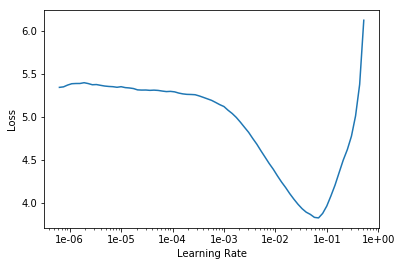

In [55]:
learner.recorder.plot()

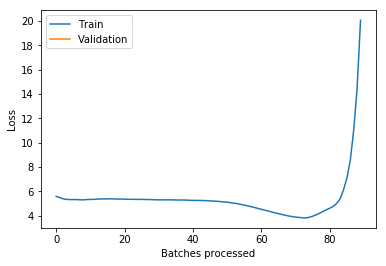

In [56]:
learner.recorder.plot_losses()

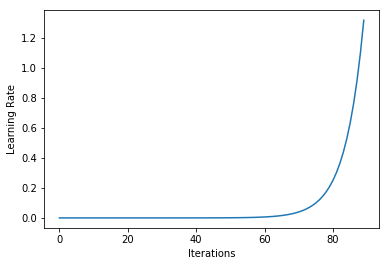

In [57]:
learner.recorder.plot_lr()

In [58]:
learner.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.529068,2.740276,0.471624,02:04
1,1.784195,1.562253,0.566047,02:00
2,1.259372,1.089114,0.676125,02:01
3,0.873007,0.650514,0.804795,02:00
4,0.586186,0.600512,0.822896,02:00


In [59]:
learner.save('224-Step1')

In [60]:
data = get_data(299, 64)

In [61]:
learner.data = data

In [62]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


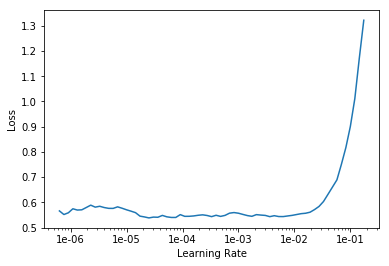

In [63]:
learner.recorder.plot()

In [64]:
learner.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.154077,2.143020,0.477495,02:53
1,1.068278,0.830655,0.752446,02:50
2,0.618948,0.572010,0.829746,02:49


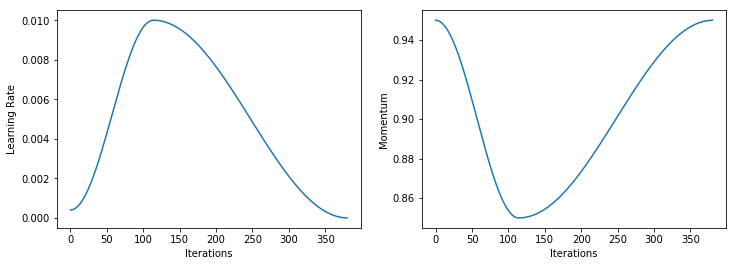

In [65]:
learner.recorder.plot_lr(show_moms=True)

In [ ]:
data = get_data(340, 32)

In [ ]:
learner = cnn_

In [67]:
learner.data = data

In [68]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


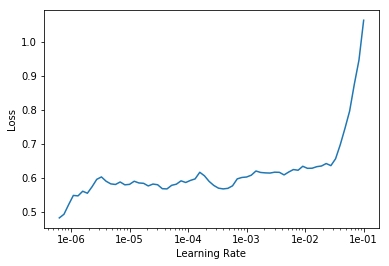

In [69]:
learner.recorder.plot()

In [70]:
learner.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.999956,1.653765,0.551859,03:32
1,1.440537,1.409753,0.615949,03:28
2,1.081782,1.014781,0.710372,03:24
3,0.721516,0.619524,0.806262,03:27
4,0.489851,0.549241,0.840020,03:25


In [71]:
learner.unfreeze()

In [72]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


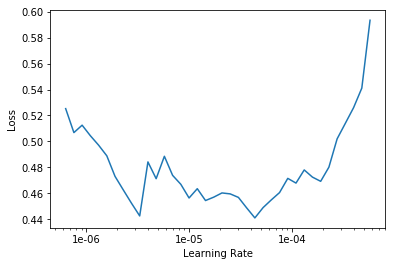

In [73]:
learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(10, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.516903,0.604529,0.826321,03:45
1,0.744608,0.930042,0.727984,03:42
2,0.857671,1.022930,0.702055,03:43
3,0.808070,0.927039,0.736301,03:44
4,0.598215,0.848267,0.741683,03:46


In [ ]:
learner = cnn_learner(data, models.resnet101, metrics=accuracy, path='.', callback_fns=partial(GradientClipping, clip=0.1))

In [ ]:
learner.fit_one_cycle(10, max_lr=slice(1e-5, 1e-3))

In [ ]:
learner.save('340-90plus')

In [ ]:
learner.load('340-90plus');

In [ ]:
learner.freeze_to(-2)

In [ ]:
learner.lr_find()

In [ ]:
learner.recorder.plot()

In [ ]:
learner.load('340-90plus');

In [ ]:
test_data = (ImageList.from_folder('../input/test')
             .split_none())

In [ ]:
test_data.transform

In [ ]:
src = (ImageList.from_folder('../input/test')
             .split_none())

In [ ]:
data = src.databunch(bs=bs).normalize(imagenet_stats)